In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

def load_data(file_path):
    """
    Load the BigQuery results from a CSV file
    """
    # Adjust the column names based on your actual BigQuery results
    df = pd.read_csv(file_path)
    
    # Ensure date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    return df

def preprocess_data(df, openai_launch_date):
    """
    Preprocess the data for analysis
    """
    # Calculate 7-day moving average to handle day-of-week effects
    df['new_repos_ma7'] = df['new_repos'].rolling(window=7, center=True).mean()
    
    # Calculate 30-day moving average for longer-term trends
    df['new_repos_ma30'] = df['new_repos'].rolling(window=30, center=True).mean()
    
    # Create a column to mark pre/post OpenAI launch
    df['post_openai'] = (df['date'] >= openai_launch_date).astype(int)
    
    # Create a time index for regression analysis
    df['time_index'] = range(len(df))
    df['time_since_openai'] = df['time_index'] * df['post_openai']
    
    return df

def plot_trends(df, openai_launch_date, save_path=None):
    """
    Plot the repository creation trends with OpenAI launch marked
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot raw data and moving averages
    axes[0].plot(df['date'], df['new_repos'], alpha=0.3, label='Daily New Repositories', color='gray')
    axes[0].plot(df['date'], df['new_repos_ma7'], label='7-day Moving Average', linewidth=2, color='blue')
    axes[0].plot(df['date'], df['new_repos_ma30'], label='30-day Moving Average', linewidth=2, color='darkgreen')
    
    # Mark OpenAI launch
    launch_date = pd.to_datetime(openai_launch_date)
    axes[0].axvline(x=launch_date, color='red', linestyle='--', label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add other significant AI releases if relevant
    # axes[0].axvline(x=pd.to_datetime('2023-03-14'), color='purple', linestyle='--', 
    #                label='GPT-4 Release (2023-03-14)')
    
    # Set title and labels
    axes[0].set_title('GitHub Repository Creation Over Time', fontsize=16)
    axes[0].set_ylabel('Number of New Repositories', fontsize=14)
    axes[0].legend(loc='upper left')
    
    # Format x-axis dates
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot percent change from previous year (YoY growth)
    # This helps identify if there's unusual growth beyond the normal yearly pattern
    df_with_yoy = calculate_yoy_growth(df)
    if 'yoy_growth' in df_with_yoy.columns:
        mask = ~df_with_yoy['yoy_growth'].isna()
        axes[1].plot(df_with_yoy.loc[mask, 'date'], 
                    df_with_yoy.loc[mask, 'yoy_growth'], 
                    label='YoY Growth %', color='orange', linewidth=2)
        axes[1].axvline(x=launch_date, color='red', linestyle='--')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_ylabel('YoY Growth %', fontsize=14)
        axes[1].legend(loc='upper left')
        
        # Format x-axis dates (same as the main plot)
        axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def calculate_yoy_growth(df):
    """
    Calculate year-over-year growth percentages
    """
    try:
        # Create a copy to avoid modifying the original dataframe
        df_yoy = df.copy()
        
        # Get values from exactly one year ago
        df_yoy['prev_year_value'] = df_yoy['new_repos_ma30'].shift(365)
        
        # Calculate YoY growth percentage
        df_yoy['yoy_growth'] = ((df_yoy['new_repos_ma30'] / df_yoy['prev_year_value']) - 1) * 100
        
        return df_yoy
    except Exception as e:
        print(f"Could not calculate YoY growth: {e}")
        return df

def perform_statistical_analysis(df, openai_launch_date):
    """
    Perform statistical analysis to quantify changes before and after OpenAI launch
    """
    # Filter to ensure we have equal time periods before and after launch for fair comparison
    launch_idx = df[df['date'] >= openai_launch_date].index[0]
    days_after_launch = len(df) - launch_idx
    days_to_use = min(launch_idx, days_after_launch)
    
    # Get equal periods before and after
    before_df = df.iloc[launch_idx - days_to_use:launch_idx]
    after_df = df.iloc[launch_idx:launch_idx + days_to_use]
    
    # Basic statistics
    before_mean = before_df['new_repos'].mean()
    after_mean = after_df['new_repos'].mean()
    percent_change = ((after_mean / before_mean) - 1) * 100
    
    print("\n===== Statistical Analysis =====")
    print(f"Time periods analyzed: {days_to_use} days before and after OpenAI launch")
    print(f"Average daily new repositories before launch: {before_mean:.2f}")
    print(f"Average daily new repositories after launch: {after_mean:.2f}")
    print(f"Percent change: {percent_change:.2f}%")
    
    # Test statistical significance (t-test)
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(before_df['new_repos'], after_df['new_repos'], equal_var=False)
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"The change is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 5% level")
    
    # Interrupted Time Series Analysis
    print("\n===== Interrupted Time Series Analysis =====")
    try:
        # Prepare data for ITS analysis
        analysis_df = df.copy()
        analysis_df['time'] = range(len(analysis_df))
        analysis_df['intervention'] = (analysis_df['date'] >= openai_launch_date).astype(int)
        analysis_df['time_after'] = analysis_df['time'] * analysis_df['intervention']
        
        # Fit the model
        model = smf.ols('new_repos ~ time + intervention + time_after', data=analysis_df).fit()
        print(model.summary().tables[1])
        
        # Interpret the key coefficients
        print("\nInterpretation:")
        if model.params['intervention'] > 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate INCREASE of {model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        elif model.params['intervention'] < 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate DECREASE of {-model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        else:
            print(f"No significant immediate change after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
            
        if model.params['time_after'] > 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation INCREASED by {model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        elif model.params['time_after'] < 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation DECREASED by {-model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        else:
            print(f"No significant change in the trend after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
            
    except Exception as e:
        print(f"Could not perform interrupted time series analysis: {e}")

def decompose_time_series(df):
    """
    Decompose the time series into trend, seasonal, and residual components
    """
    try:
        # Ensure we have no missing values
        df_decomp = df.copy()
        df_decomp = df_decomp.dropna(subset=['new_repos'])
        
        # Set date as index for decomposition
        df_decomp = df_decomp.set_index('date')
        
        # Perform decomposition (adjust period based on your data - e.g., 7 for weekly patterns)
        decomposition = seasonal_decompose(df_decomp['new_repos'], model='additive', period=7)
        
        # Plot the decomposition
        fig, axes = plt.subplots(4, 1, figsize=(14, 16))
        
        decomposition.observed.plot(ax=axes[0])
        axes[0].set_title('Observed', fontsize=14)
        
        decomposition.trend.plot(ax=axes[1])
        axes[1].set_title('Trend', fontsize=14)
        
        decomposition.seasonal.plot(ax=axes[2])
        axes[2].set_title('Seasonal', fontsize=14)
        
        decomposition.resid.plot(ax=axes[3])
        axes[3].set_title('Residual', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
        
    except Exception as e:
        print(f"Could not perform time series decomposition: {e}")
        return None

Loaded data with 2183 rows from 2019-01-01 00:00:00 to 2024-12-31 00:00:00


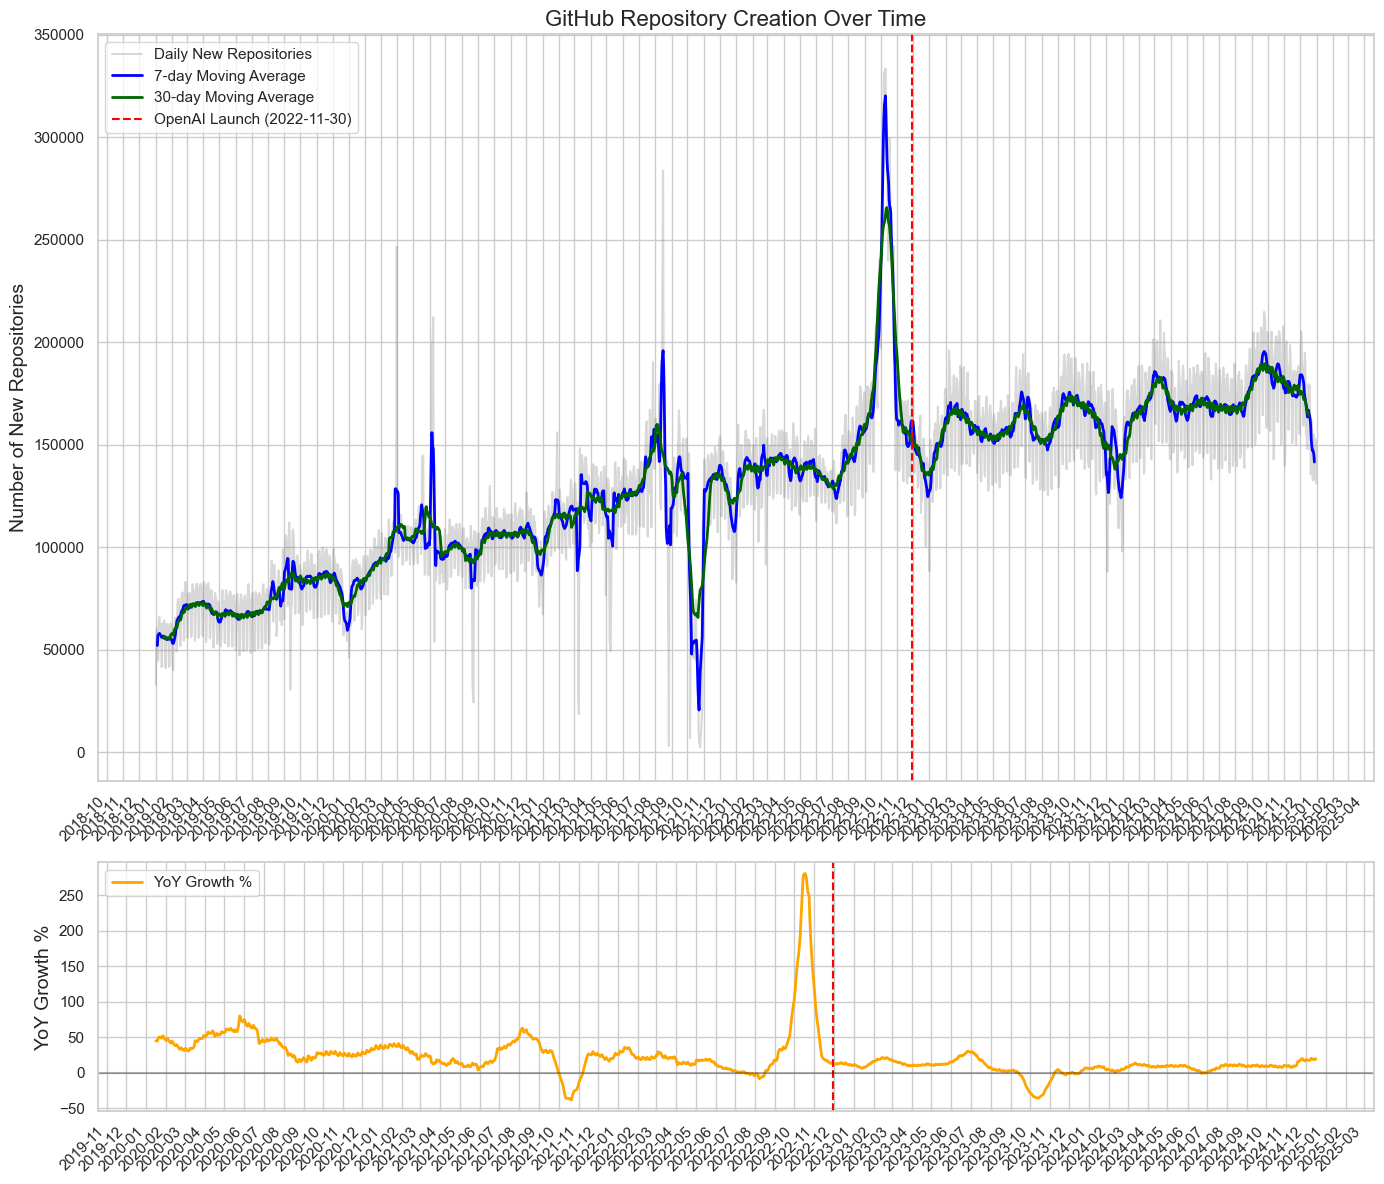


===== Statistical Analysis =====
Time periods analyzed: 763 days before and after OpenAI launch
Average daily new repositories before launch: 134361.48
Average daily new repositories after launch: 164233.70
Percent change: 22.23%
t-statistic: -18.2782
p-value: 0.0000
The change is statistically significant at the 5% level

===== Interrupted Time Series Analysis =====
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.836e+04   1333.319     43.771      0.000    5.57e+04     6.1e+04
time            74.6916      1.627     45.902      0.000      71.501      77.883
intervention  4.253e+04   7613.481      5.586      0.000    2.76e+04    5.75e+04
time_after     -39.5205      4.440     -8.901      0.000     -48.228     -30.813

Interpretation:
There was an immediate INCREASE of 42529.38 repositories after the OpenAI launch (p=0.0000)
The SLOPE of repository creation D

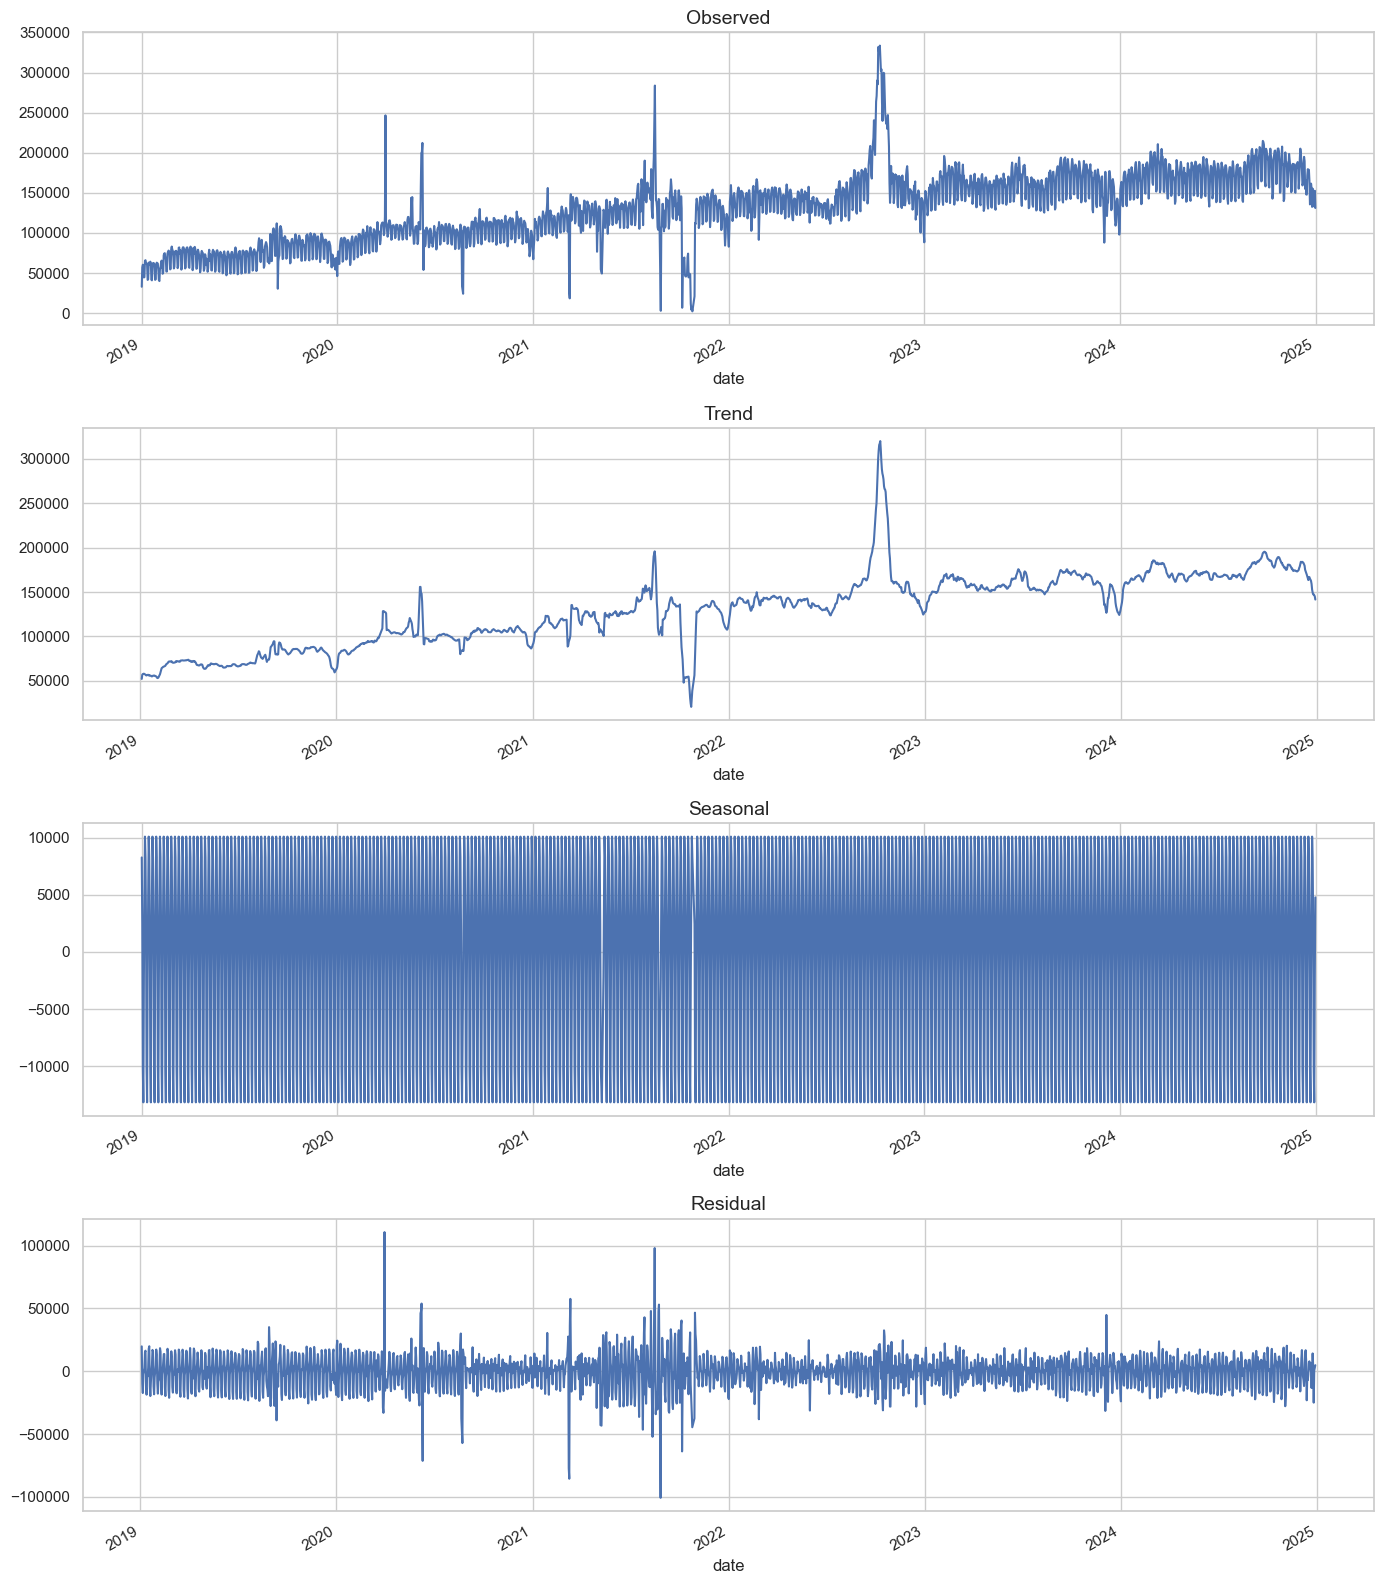

In [2]:
file_path = "bq-results.csv"  # Update this to your actual file path
openai_launch_date = "2022-11-30"
df = load_data(file_path)
print(f"Loaded data with {len(df)} rows from {df['date'].min()} to {df['date'].max()}")
df = preprocess_data(df, openai_launch_date)
plot_trends(df, openai_launch_date, save_path="github_repo_trends.png")
perform_statistical_analysis(df, openai_launch_date)
decomposition = decompose_time_series(df)